In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import xarray
from glmtools.io.glm import GLMDataset

In [2]:
import os
from glmtools.test.common import get_test_dataset, get_sample_data_list
glm, flash_ids = get_test_dataset()

## Interactively view flashes one at a time

In [3]:
from glmtools.plot.locations import plot_flash

# fl_id_vals = list(glm.dataset.flash_id.data)
fl_id_vals = flash_ids
fl_id_vals.sort()
flash_slider =  widgets.SelectionSlider(
    description='Flash',
    options=fl_id_vals,
)

def do_plot(flash_id):
    this_flash = glm.get_flashes([flash_id])
    fig = plot_flash(glm, flash_id)
    plt.show() # prevents multiple plots - see ipywidgets issue #1179 on github
interactor = widgets.interact(do_plot, flash_id=flash_slider)

## Create and plot grids of the data above

In [5]:
import subprocess
import os, glob
import tempfile
tmpdir = tempfile.TemporaryDirectory()

import glmtools
from glmtools.test.common import get_sample_data_path
glmtools_path = os.path.abspath(glmtools.__path__[0])
glmfile = os.path.join(get_sample_data_path(), 'FGE_split_merge_GLM.nc')
    
cmd = "python {0}/../examples/grid/make_GLM_grids.py -o {1} "
cmd += " --ctr_lat=35.0 --ctr_lon=-95.0 --width=100 --height=100 "
cmd += " --start=2017-04-26T12:30:00 --end=2017-04-26T12:31:00 {2}"

cmd = cmd.format(glmtools_path, tmpdir.name, glmfile)
print (cmd)
out_bytes = subprocess.check_output(cmd.split())
print(out_bytes.decode('utf-8'))

nc_files = glob.glob(os.path.join(tmpdir.name, '2017/Apr/26/*.nc'))
print(nc_files)

python /Users/ebruning/code/glmtools/glmtools/../examples/grid/make_GLM_grids.py -o /var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpuhgc30b2  --ctr_lat=35.0 --ctr_lon=-95.0 --width=100 --height=100  --start=2017-04-26T12:30:00 --end=2017-04-26T12:31:00 /Users/ebruning/code/glmtools/glmtools/test/data/FGE_split_merge_GLM.nc

['/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpuhgc30b2/2017/Apr/26/GLM_20170426_123000_60_1src_0.1095deg-dx_flash_extent.nc', '/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpuhgc30b2/2017/Apr/26/GLM_20170426_123000_60_1src_0.1095deg-dx_flash_init.nc', '/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpuhgc30b2/2017/Apr/26/GLM_20170426_123000_60_1src_0.1095deg-dx_footprint.nc', '/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpuhgc30b2/2017/Apr/26/GLM_20170426_123000_60_1src_0.1095deg-dx_group_area.nc', '/var/folders/sp/7k9p40wj1x9fdvwjbdrs4ffm0000gn/T/tmpuhgc30b2/2017/Apr/26/GLM_20170426_123000_60_1src_0.1095deg-dx_group_extent.nc', '/var/folde

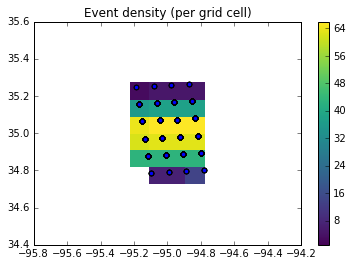

In [7]:
# from lmatools.grid.make_grids import centers_to_edges
from lmatools.vis.multiples_nc import centers_to_edges
import matplotlib
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
grid_filename = tmpdir.name+'/2017/Apr/26/GLM_20170426_123000_60_1src_0.1095deg-dx_source.nc'
extent_grid = xarray.open_dataset(grid_filename)
lats, lons = extent_grid.latitude.data, extent_grid.longitude.data
counts = extent_grid.event_density.data[0,:,:]
counts = np.ma.masked_where((counts<1), counts)
plt.pcolormesh(centers_to_edges(lons), centers_to_edges(lats), counts.T, cmap='viridis', vmin=1)
plt.colorbar()
plt.scatter(glm.dataset.event_lon.data, glm.dataset.event_lat.data)
plt.title('Event density (per grid cell)')
# flash_grid.flash_extent.plot()

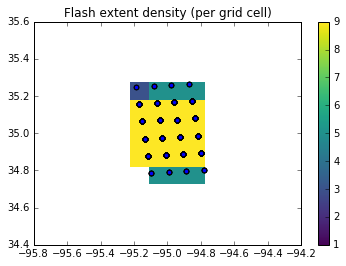

In [8]:
grid_filename = tmpdir.name+'/2017/Apr/26/GLM_20170426_123000_60_1src_0.1095deg-dx_flash_extent.nc'
extent_grid = xarray.open_dataset(grid_filename)
lats, lons = extent_grid.latitude.data, extent_grid.longitude.data
counts = extent_grid.flash_extent_density.data[0,:,:]
counts = np.ma.masked_where((counts<1), counts)
plt.pcolormesh(centers_to_edges(lons), centers_to_edges(lats), counts.T, cmap='viridis', vmin=1)
plt.colorbar()
plt.scatter(glm.dataset.event_lon.data, glm.dataset.event_lat.data)
plt.title('Flash extent density (per grid cell)')
# flash_grid.flash_extent.plot()

In [9]:
tmpdir.cleanup()